In [1]:
import numpy as np
import pandas as pd,sklearn, re, random
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2
import os
import zipfile

import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

random_state = 2020
import matplotlib.gridspec as gridspec

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

In [2]:
train_images1 = 'C:\\Personal\\AI\\Computer_Vision\\PINS.zip'

In [3]:
archive = zipfile.ZipFile(train_images1, 'r')
archive.extractall()

In [4]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [5]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels, CV2 used to open file cv2.imread()
    # method loads an image from the specified file. If the image cannot be read 
    #(because of the missing file, improper permissions, or unsupported or invalid format) 
    #then this method returns an empty matrix.
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [6]:
metadata= load_metadata('C:\Personal\AI\Computer_Vision\PINS')
labels = np.array([meta.name for meta in metadata])

In [7]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

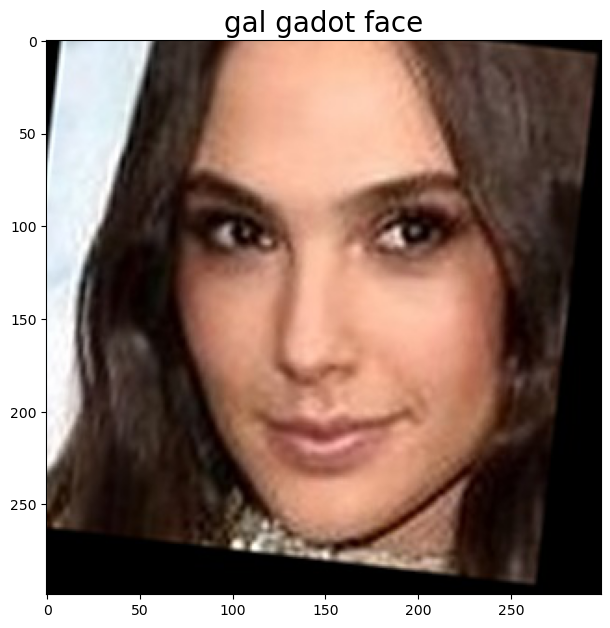

In [8]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [9]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [10]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [11]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [12]:
img_path = metadata[0].image_path()
img = load_image(img_path)

img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
(2622,)


In [13]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
for i, meta in enumerate(metadata):
  try:
    image = load_image(str(meta))
    image = (image/255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 199ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 211ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 1s 584ms/step


1/1 [==============================] - 1s 533ms/step


1/1 [==============================] - 1s 522ms/step


1/1 [==============================] - 1s 655ms/step


1/1 [==============================] - 1s 677ms/step


1/1 [==============================] - 1s 744ms/step


1/1 [==============================] - 1s 688ms/step


1/1 [==============================] - 1s 688ms/step


1/1 [==============================] - 1s 893ms/step


1/1 [==============================] - 1s 776ms/step


1/1 [==============================] - 1s 781ms/step


1/1 [==============================] - 1s 956ms/step


1/1 [==============================] - 1s 944ms/step


1/1 [==============================] - 1s 969ms/step


1/1 [==============================] - 1s 969ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 915ms/step


1/1 [==============================] - 1s 870ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


In [14]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [15]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))  

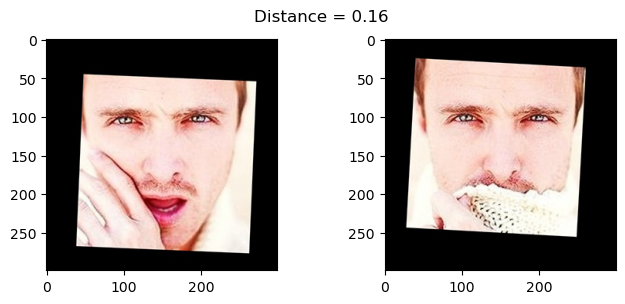

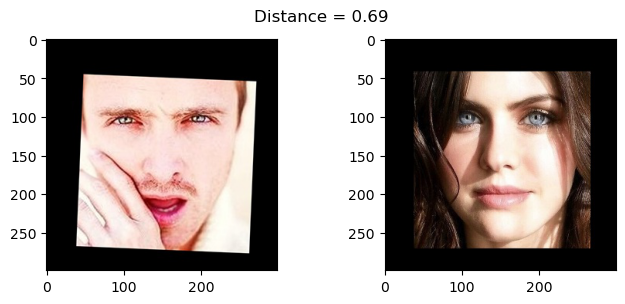

In [16]:
show_pair(2, 3)
show_pair(2, 180)

In [17]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [18]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

In [19]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [20]:
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.58548381  18.9502517   22.94392242 ...  99.99999983  99.99999999
 100.        ]


In [21]:
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 346


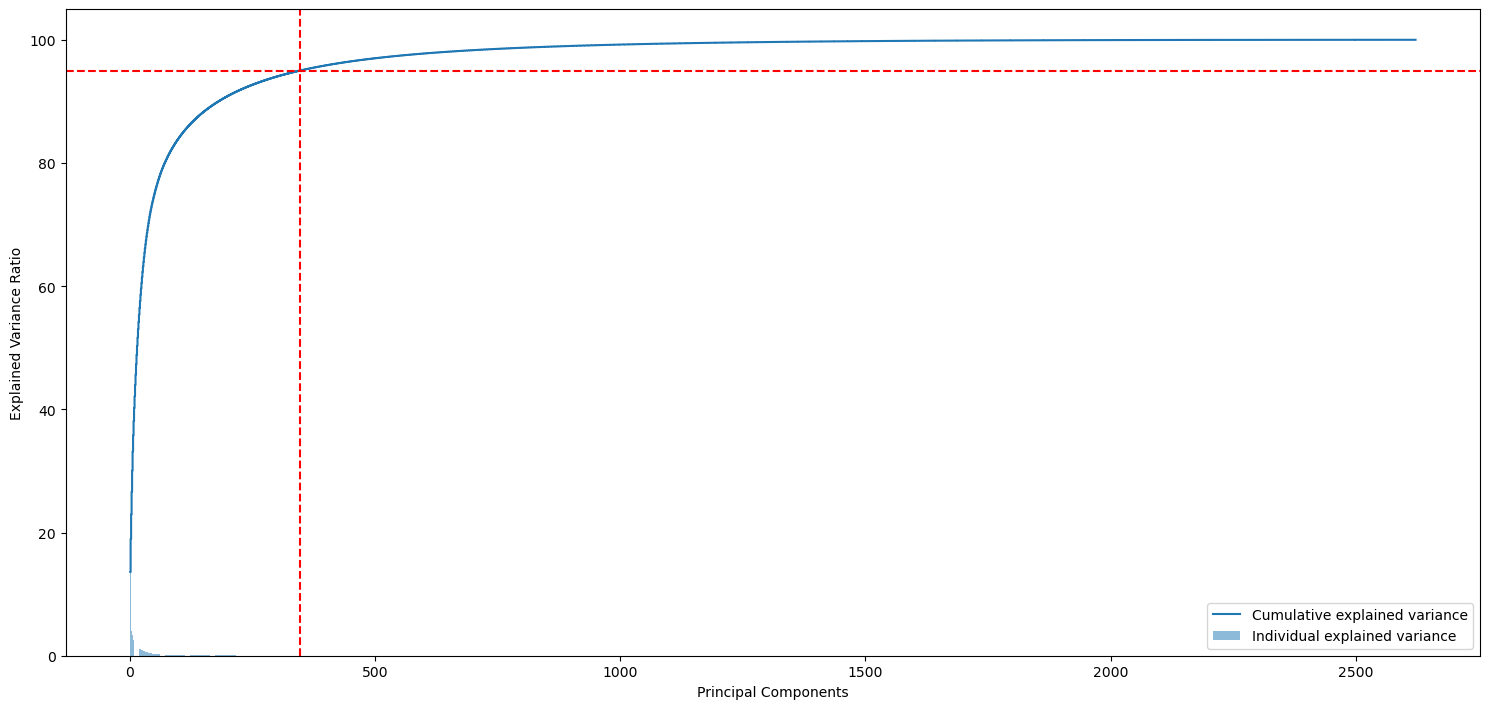

In [22]:
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [23]:
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 346)

(1197, 346)

In [24]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [25]:
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Accuracy Score: 0.966


In [26]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      1.00      1.00        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      1.00      1.00         7
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       1.00      1.00      1.00        14
           Anne Hathaway       1.00      1.00      1.00        14
     Barbara Palvin Face       1.00      1.00      1.00         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      1.00      1.00        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       1.00      0.90      

In [27]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 2s 2s/step


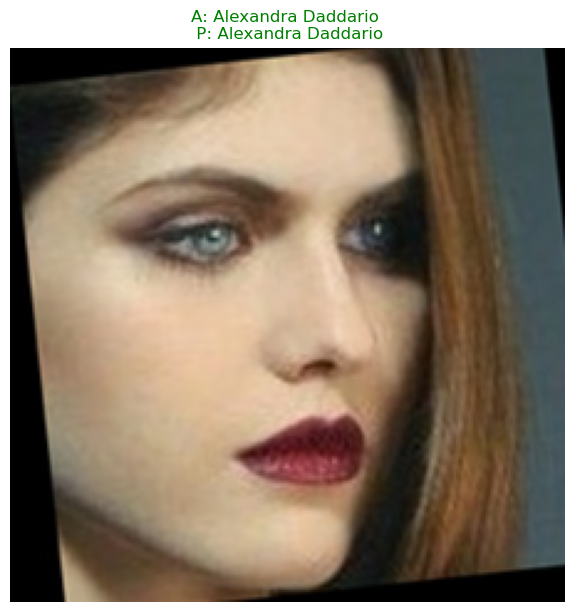

In [28]:
sample_img, actual_name, pred_name = sample_img_plot(10)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 [==============================] - 2s 2s/step


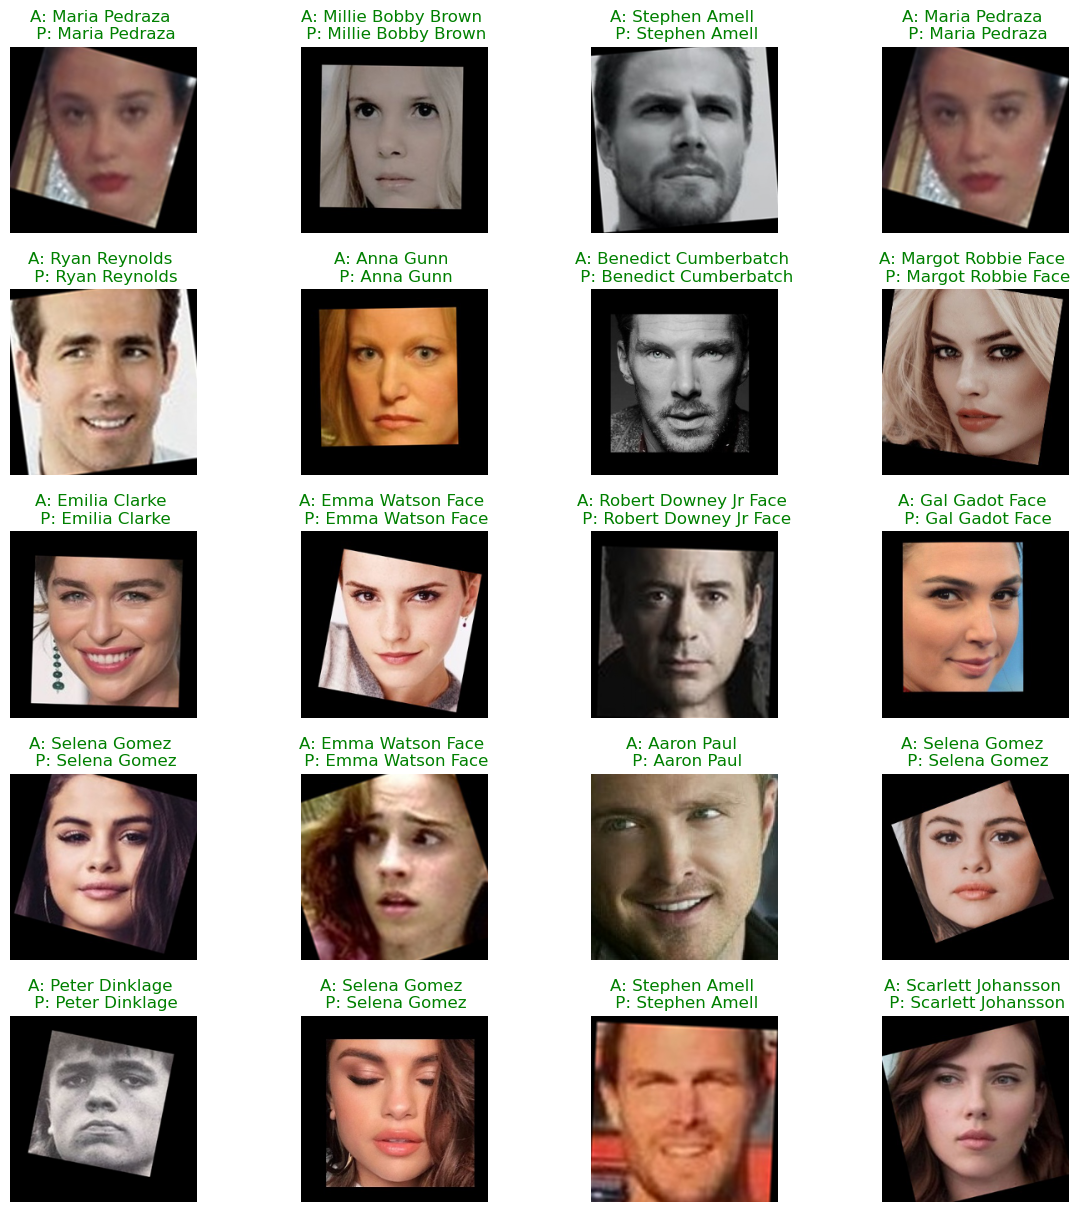

In [29]:
plt.figure(figsize = (15, 15))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.3) 

for i in range(20):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))
  
    plt.axis('off')
    plt.imshow(sample_img)
  
    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

Task here was to recognize (aligned) faces from a dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition.

VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.
Distance between two pair of images were also calculated and plotted.
Since, there were 2,622 features for each image, PCA was used for dimension reduction after standardizing the features.
With an cumulative explained variance of 95%, 347 PCA components were used.
Using SVC we predicted the labels for test dataset with an accuracy of more than 96%.
Also compared predicted and actual labels for a given sample image as well as for 20 random images from test dataset.